<a href="https://colab.research.google.com/github/Lalit767/Expedia_Case_Study/blob/main/SeasonalityAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87856 entries, 0 to 87855
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                87856 non-null  object
 1   Geographic Region   87856 non-null  object
 2   Platform            87856 non-null  object
 3   Marketing Channel   87856 non-null  object
 4   Visits              87856 non-null  int64 
 5   Qualified Shoppers  87856 non-null  int64 
 6   Bounced Visits      87856 non-null  int64 
 7   Gross Orders        87856 non-null  int64 
 8   Net Orders          87856 non-null  int64 
 9   Net Room Nights     87856 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 6.7+ MB


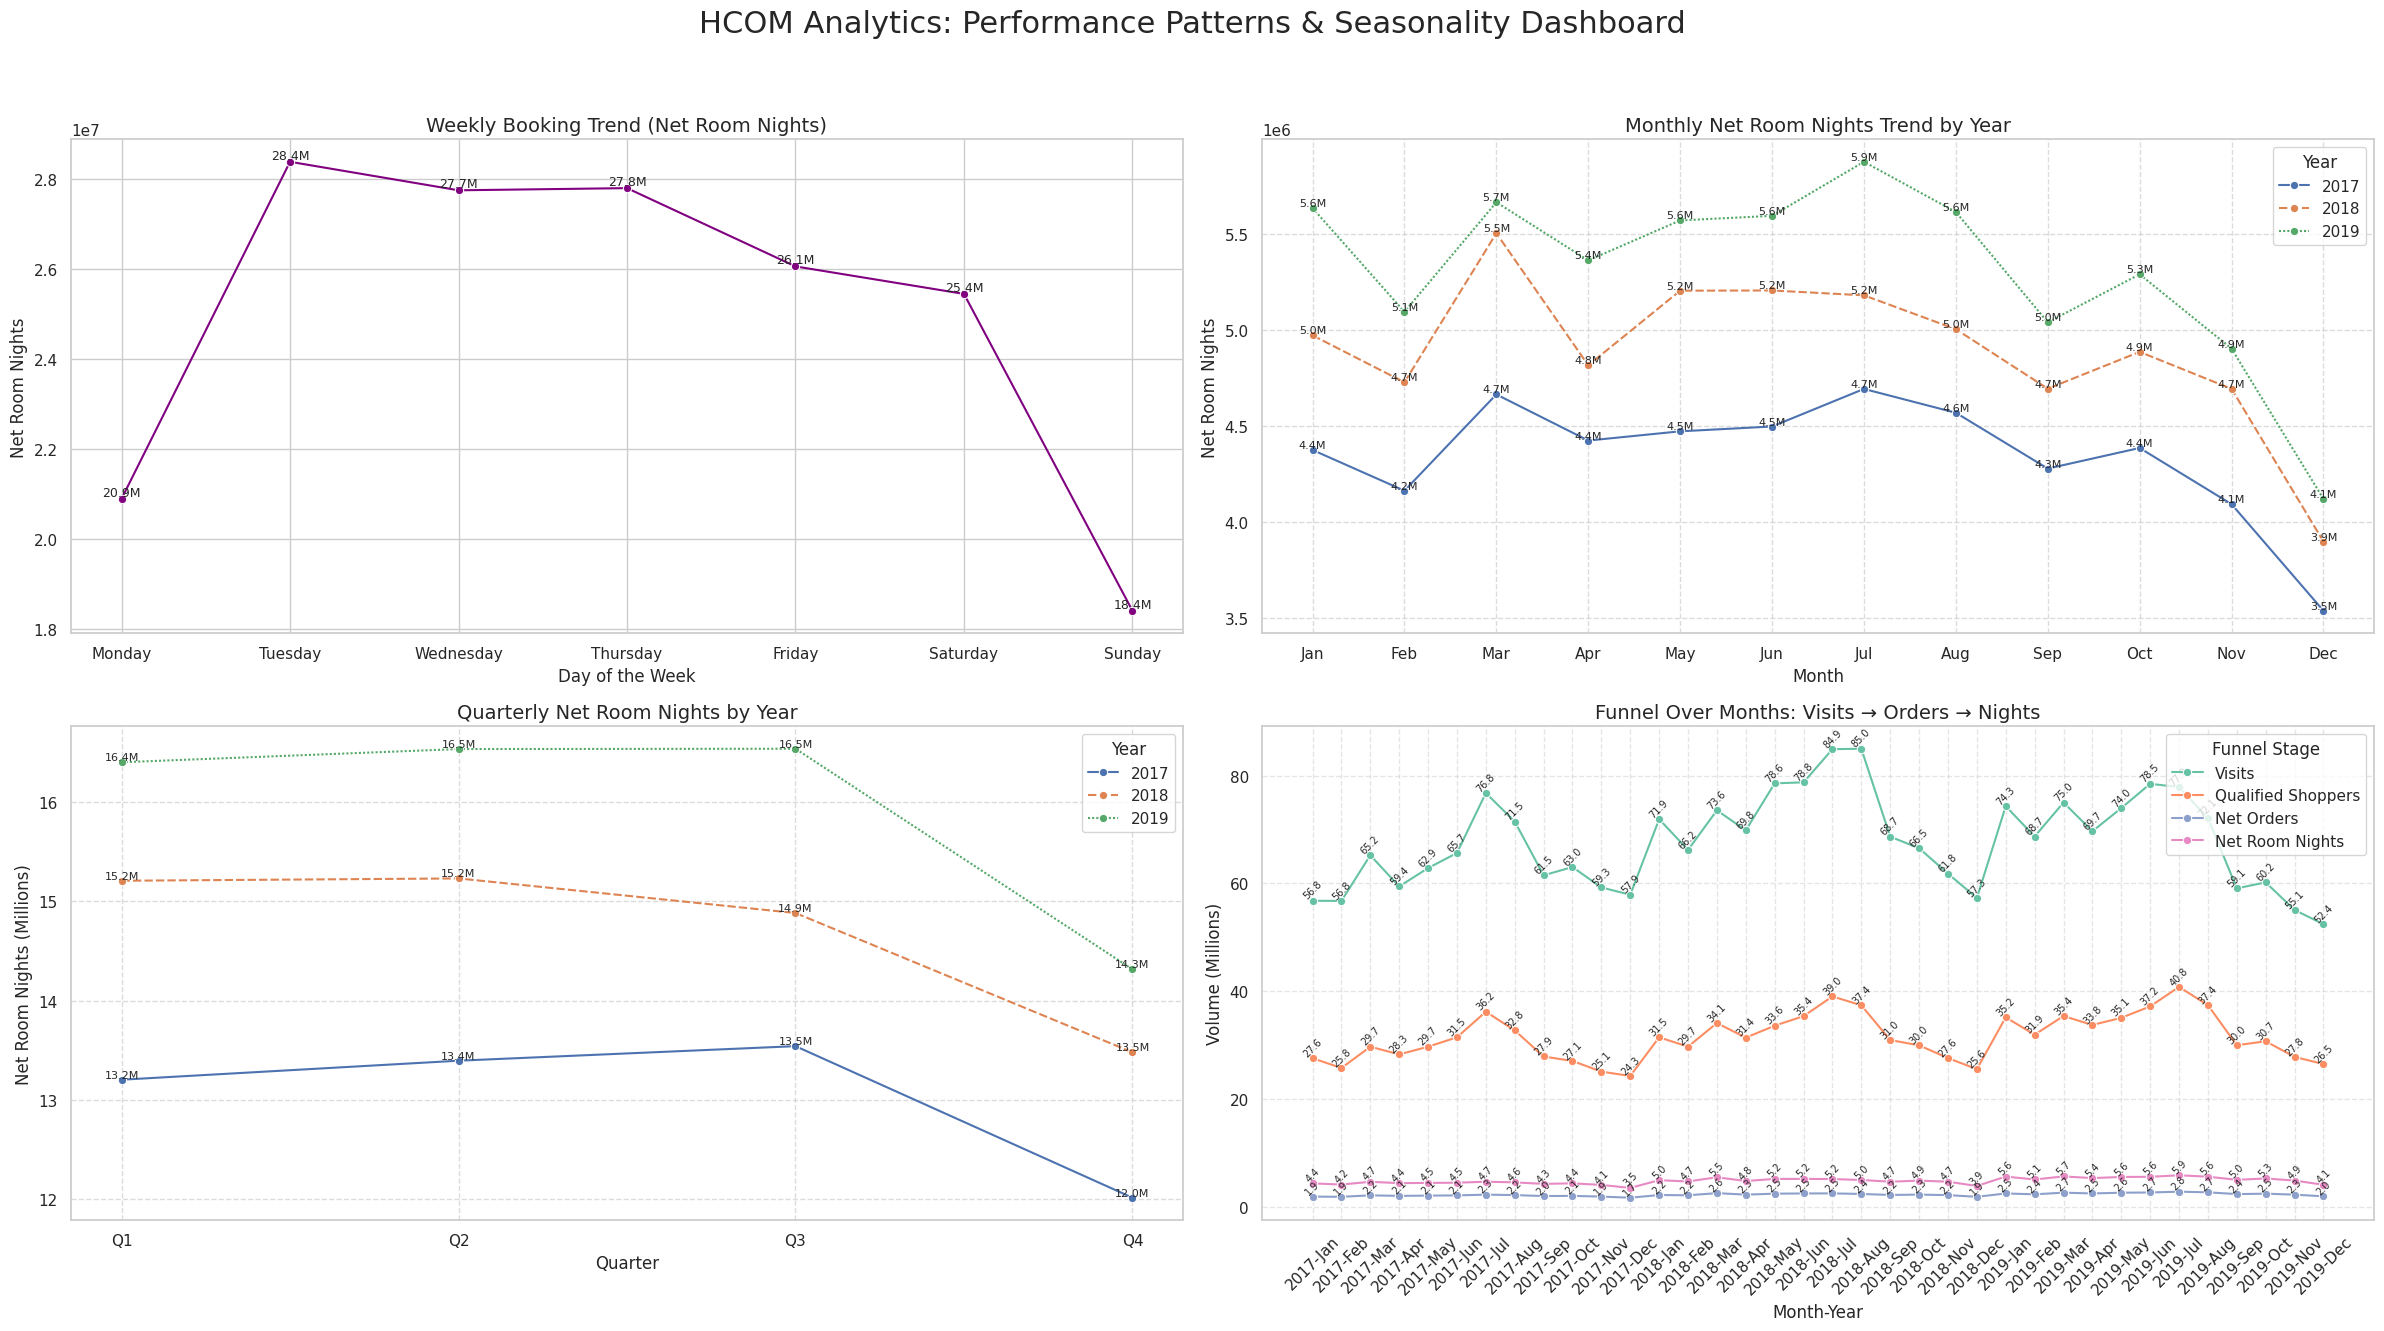

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and parse dates
df = pd.read_csv("/content/sample_data/HCOM_Analytics_Insights_Case_Study_Dataset.csv", parse_dates=["Date"])

# ----- Funnel Over Time (daily funnel summary) -----
daily_funnel = df.groupby("Date")[["Visits", "Qualified Shoppers", "Net Orders", "Net Room Nights"]].sum().reset_index()
funnel_data = daily_funnel.melt(
    id_vars="Date",
    value_vars=["Visits", "Qualified Shoppers", "Net Orders", "Net Room Nights"],
    var_name="Funnel Stage",
    value_name="Count"
)
funnel_data["Count (M)"] = (funnel_data["Count"] / 1e6).round(2)

#Data Cleasing
# ----`Data Information ------
df.info()
df.describe()

# Step 1: Remove rows with invalid dates
df = df[pd.to_datetime(df['Date'], errors='coerce').notna()].copy()


# Step 2: Remove duplicate rows
df = df.drop_duplicates()

# Step 3: Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Columns to check
numeric_columns = ['Visits', 'Qualified Shoppers', 'Bounced Visits', 'Gross Orders', 'Net Orders', 'Net Room Nights']


# ----- WEEKLY trend -----
df["Weekday"] = df["Date"].dt.day_name()
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_trends = df.groupby("Weekday")["Net Room Nights"].sum().reindex(weekday_order)

# ----- MONTHLY trend -----
df["MonthName"] = df["Date"].dt.strftime('%b')
df["Year"] = df["Date"].dt.year
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_trends = df.groupby(['Year', 'MonthName'])['Net Room Nights'].sum().reset_index()
monthly_trends["MonthName"] = pd.Categorical(monthly_trends["MonthName"], categories=month_order, ordered=True)
monthly_trends = monthly_trends.sort_values(['MonthName', 'Year'])
pivot_monthly = monthly_trends.pivot(index='MonthName', columns='Year', values='Net Room Nights')

# ----- QUARTERLY trend -----
df["Quarter"] = df["Date"].dt.to_period("Q").astype(str).str[-2:]
quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
quarterly_trends = df.groupby(["Year", "Quarter"])["Net Room Nights"].sum().reset_index()
quarterly_trends["Net Room Nights (M)"] = quarterly_trends["Net Room Nights"] / 1_000_000
quarterly_trends["Quarter"] = pd.Categorical(quarterly_trends["Quarter"], categories=quarter_order, ordered=True)
pivot_quarterly = quarterly_trends.pivot(index="Quarter", columns="Year", values="Net Room Nights (M)").sort_index()

# ----- Create Dashboard: Weekly and Monthly Trends -----
# Set seaborn style
sns.set(style="whitegrid")

# Create 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(24, 14))
fig.suptitle("HCOM Analytics: Performance Patterns & Seasonality Dashboard", fontsize=22, y=0.98)

# --- Chart 1: Weekly Trend ---
sns.lineplot(x=weekday_trends.index, y=weekday_trends.values, marker='o', color='purple', ax=axs[0, 0])
axs[0, 0].set_title("Weekly Booking Trend (Net Room Nights)", fontsize=14)
axs[0, 0].set_xlabel("Day of the Week")
axs[0, 0].set_ylabel("Net Room Nights")
axs[0, 0].grid(True)
for i, value in enumerate(weekday_trends.values):
    axs[0, 0].text(i, value, f'{value/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

# --- Chart 2: Monthly Trend ---
sns.lineplot(data=pivot_monthly, marker='o', ax=axs[0, 1])
axs[0, 1].set_title("Monthly Net Room Nights Trend by Year", fontsize=14)
axs[0, 1].set_xlabel("Month")
axs[0, 1].set_ylabel("Net Room Nights")
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
for year in pivot_monthly.columns:
    for i, value in enumerate(pivot_monthly[year]):
        if pd.notna(value):
            axs[0, 1].text(i, value, f'{value/1e6:.1f}M', ha='center', va='bottom', fontsize=8)

# --- Chart 3: Quarterly Trend ---
sns.lineplot(data=pivot_quarterly, marker='o', ax=axs[1, 0])
axs[1, 0].set_title("Quarterly Net Room Nights by Year", fontsize=14)
axs[1, 0].set_xlabel("Quarter")
axs[1, 0].set_ylabel("Net Room Nights (Millions)")
axs[1, 0].grid(True, linestyle='--', alpha=0.7)
for year in pivot_quarterly.columns:
    for i, value in enumerate(pivot_quarterly[year]):
        if pd.notna(value):
            axs[1, 0].text(i, value, f'{value:.1f}M', ha='center', va='bottom', fontsize=8)

# --- Chart 4: Funnel Over Time ---
# Get subplot axis
ax_funnel = axs[1, 1]
sns.lineplot(data=funnel_melt, x="YearMonth", y="Count (M)", hue="Funnel Stage", marker="o", ax=ax_funnel, palette="Set2")
ax_funnel.set_title("Funnel Over Months: Visits → Orders → Nights", fontsize=14)
ax_funnel.set_xlabel("Month-Year")
ax_funnel.set_ylabel("Volume (Millions)")
ax_funnel.tick_params(axis='x', rotation=45)
ax_funnel.grid(True, linestyle='--', alpha=0.5)
# Add data labels
for stage in funnel_melt["Funnel Stage"].unique():
    stage_data = funnel_melt[funnel_melt["Funnel Stage"] == stage]
    for x, y in zip(stage_data["YearMonth"], stage_data["Count (M)"]):
        ax_funnel.text(x, y, f"{y:.1f}", ha="center", va="bottom", fontsize=7, rotation=45)

# Final layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("All_Trend_Dashboard.png")
plt.show()